In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt

import utils
from utils.download import get_data
from utils.var import calculate_var, exceeds_vector, test_exceeds_vector
from utils.methods import weighted_var, garch_var

In [2]:
_ = importlib.reload(utils.download)
_ = importlib.reload(utils.var)

In [3]:
raw_data, params = get_data(yahoo=True)

[*********************100%%**********************]  1 of 1 completed


In [4]:
frequency = params['frequency']
alpha95 = 95
alpha99 = 99

In [5]:
data = raw_data.resample(frequency).last()

In [6]:
data['returns'] = data.interpolate(type='linear').pct_change()

# Metoda historyczna

In [7]:
data = calculate_var(data, lambda x, alpha: np.quantile(x, alpha95/100), 'hist')
data = calculate_var(data, lambda x, alpha: np.quantile(x, alpha99/100), 'hist', alpha=alpha99)

Wykres zwrotów i VaR95 dla zwrotów.

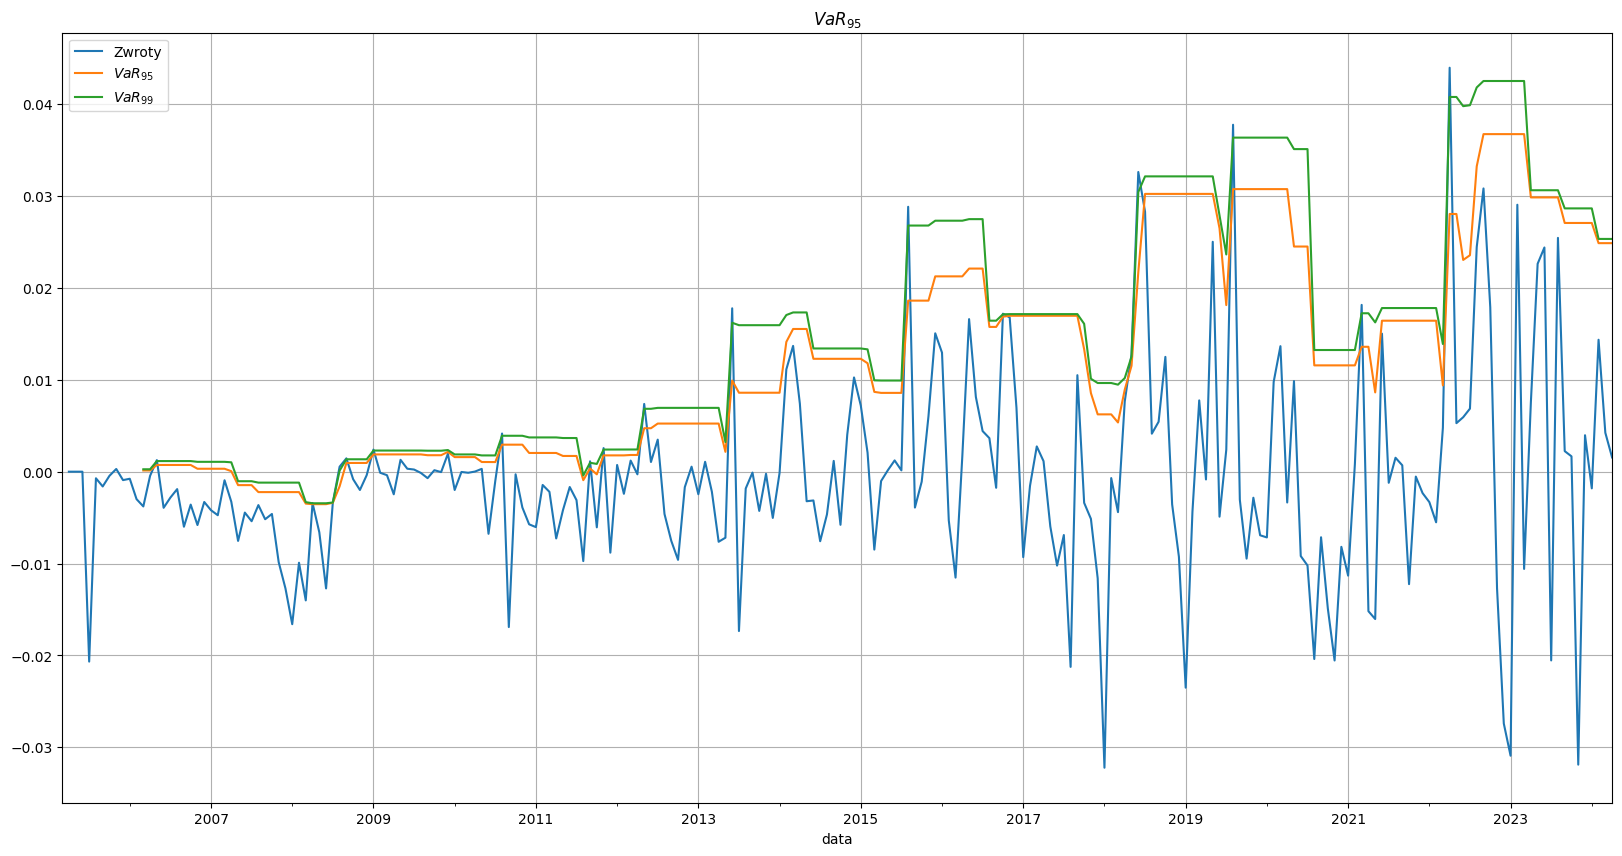

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist', 'var99_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{99}$'])
plt.savefig(f"pics\\{params['name']}\\var95.png")

Wykres cen i VaR95 dla cen.

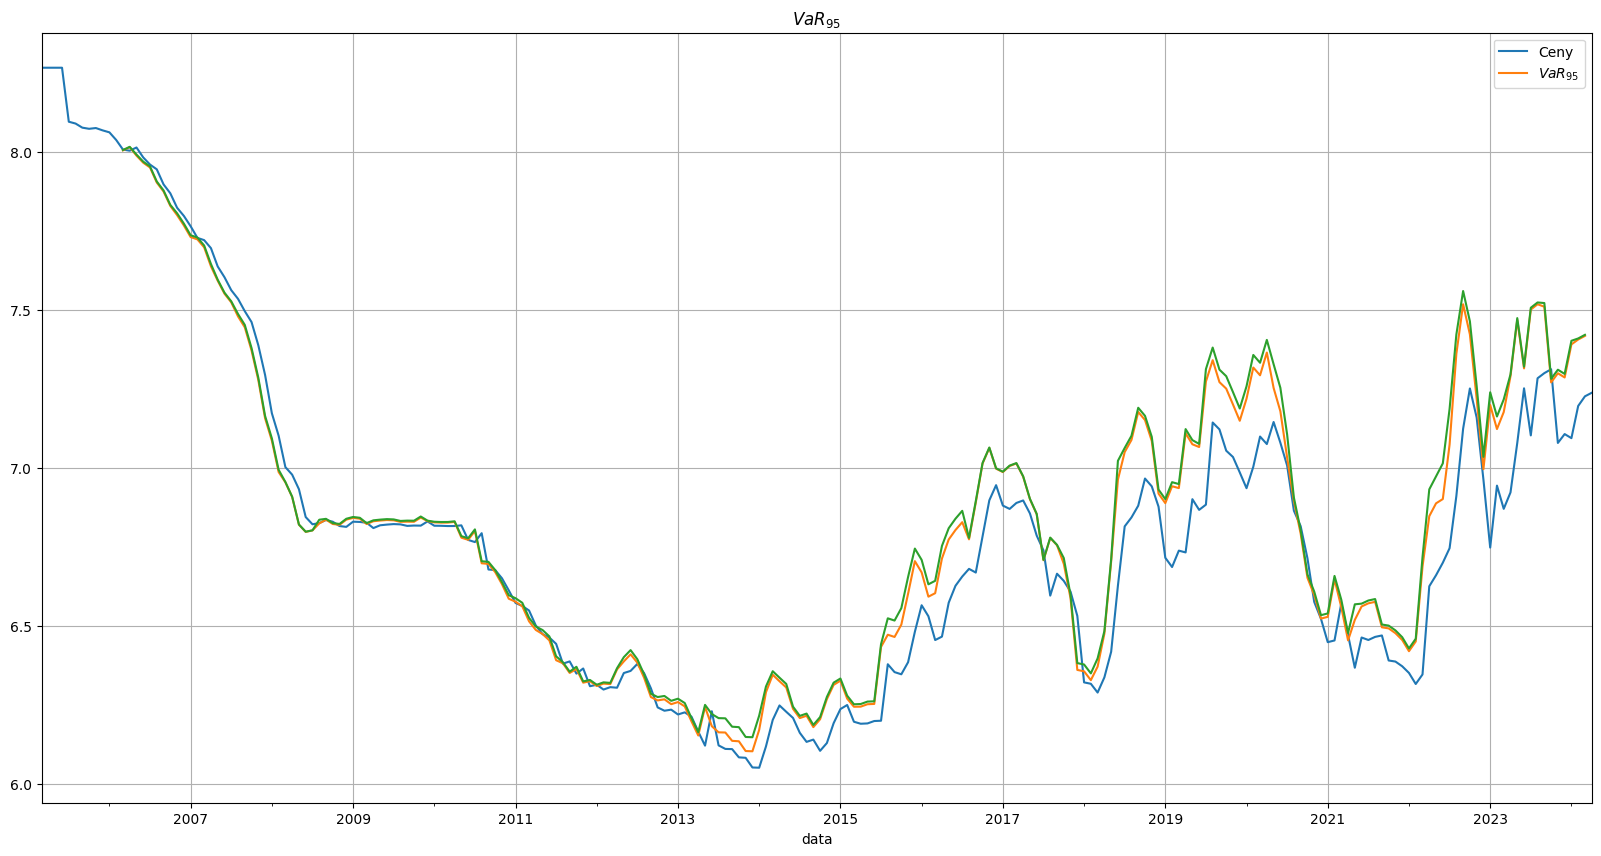

In [9]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['Close', 'VaR95_hist', 'VaR99_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Ceny', '$VaR_{95}$'])
plt.savefig(f"pics\\{params['name']}\\var95_ceny.png")

In [10]:
data, I95 = exceeds_vector(data, 'hist')  # I - wektor przekroczeń
data, I99 = exceeds_vector(data, 'hist', alpha99)

Wykres procentu przekroczeń dla okien 50.

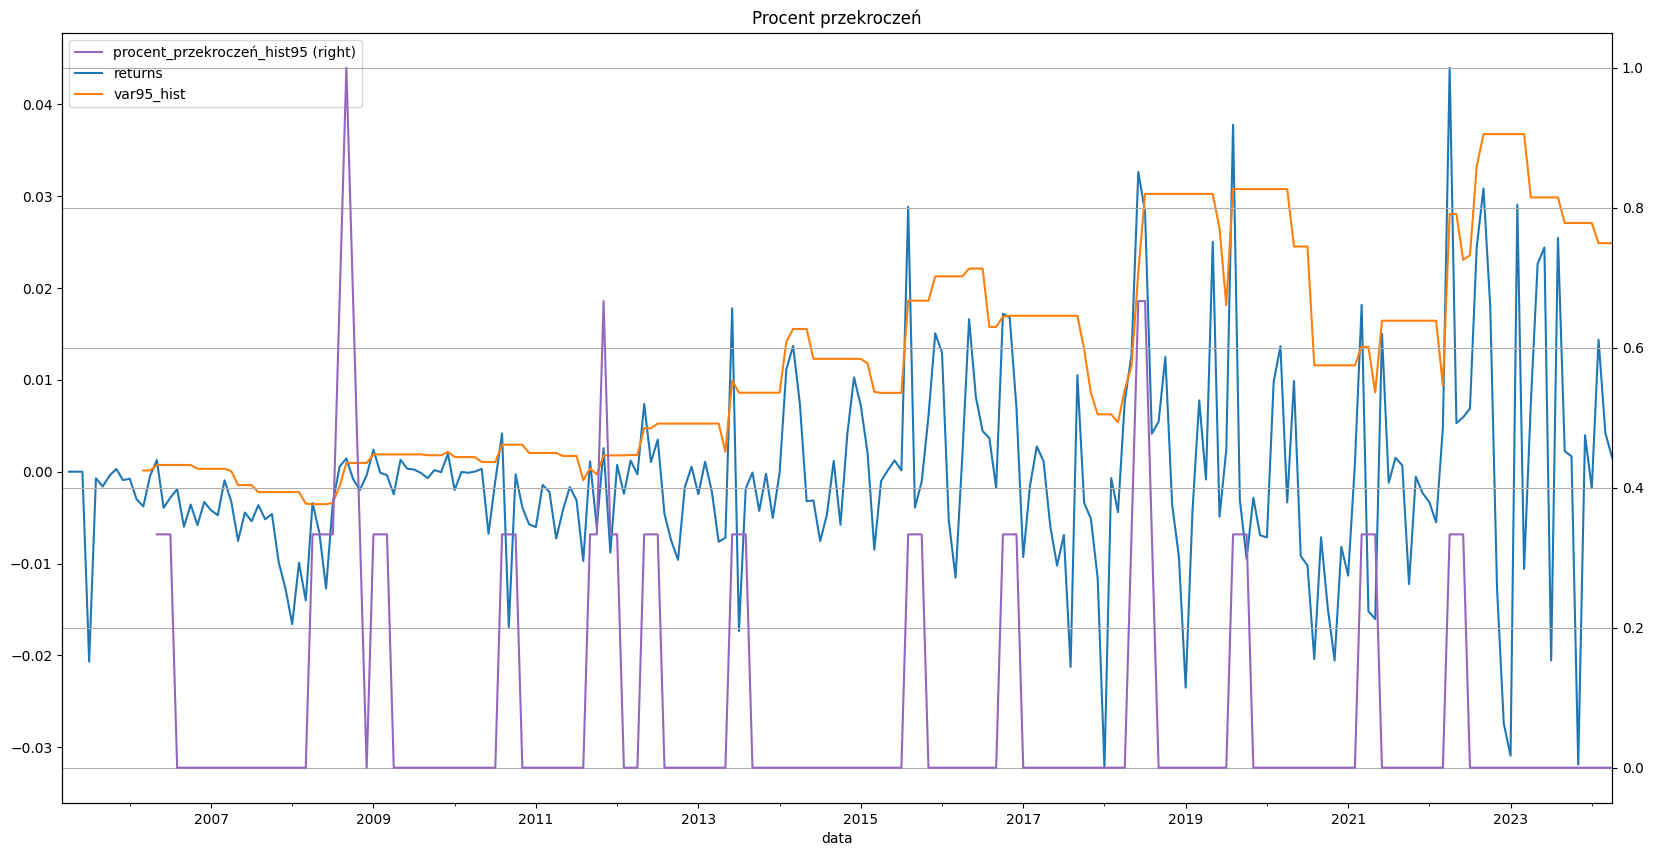

In [12]:
_, ax = plt.subplots(figsize=(20,10))
line1 = data[['procent_przekroczeń_hist95']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            legend=True)

_ = data[['returns', 'var95_hist']].plot(ax=ax,
                                         grid=True,
                                         style=['-', '-'],
                                         color=['C0', 'C1'],
                                         xlabel='data',
                                         title='Procent przekroczeń', legend=True)
plt.savefig(f"pics\\{params['name']}\\procent-var95.png")

## Testowanie wsteczne

### Testy oparte o wektor przekroczeń

In [40]:
test_exceeds_vector(I95, .95)

,empiryczne,teoretyczne
średnia,0.082569,0.9500
wariancja,0.0761,0.0475
binomtest p-wartość,0.040785,NaN
Kupiec - wynik,reject H0,NaN


# Metoda ważonej symulacji historycznej

In [41]:
data = calculate_var(data, weighted_var, 'ważona')
data = calculate_var(data, lambda x, alpha: weighted_var(x, alpha95/100), 'ważona')
data = calculate_var(data, lambda x, alpha: weighted_var(x, alpha99/100), 'ważona', alpha=alpha99)

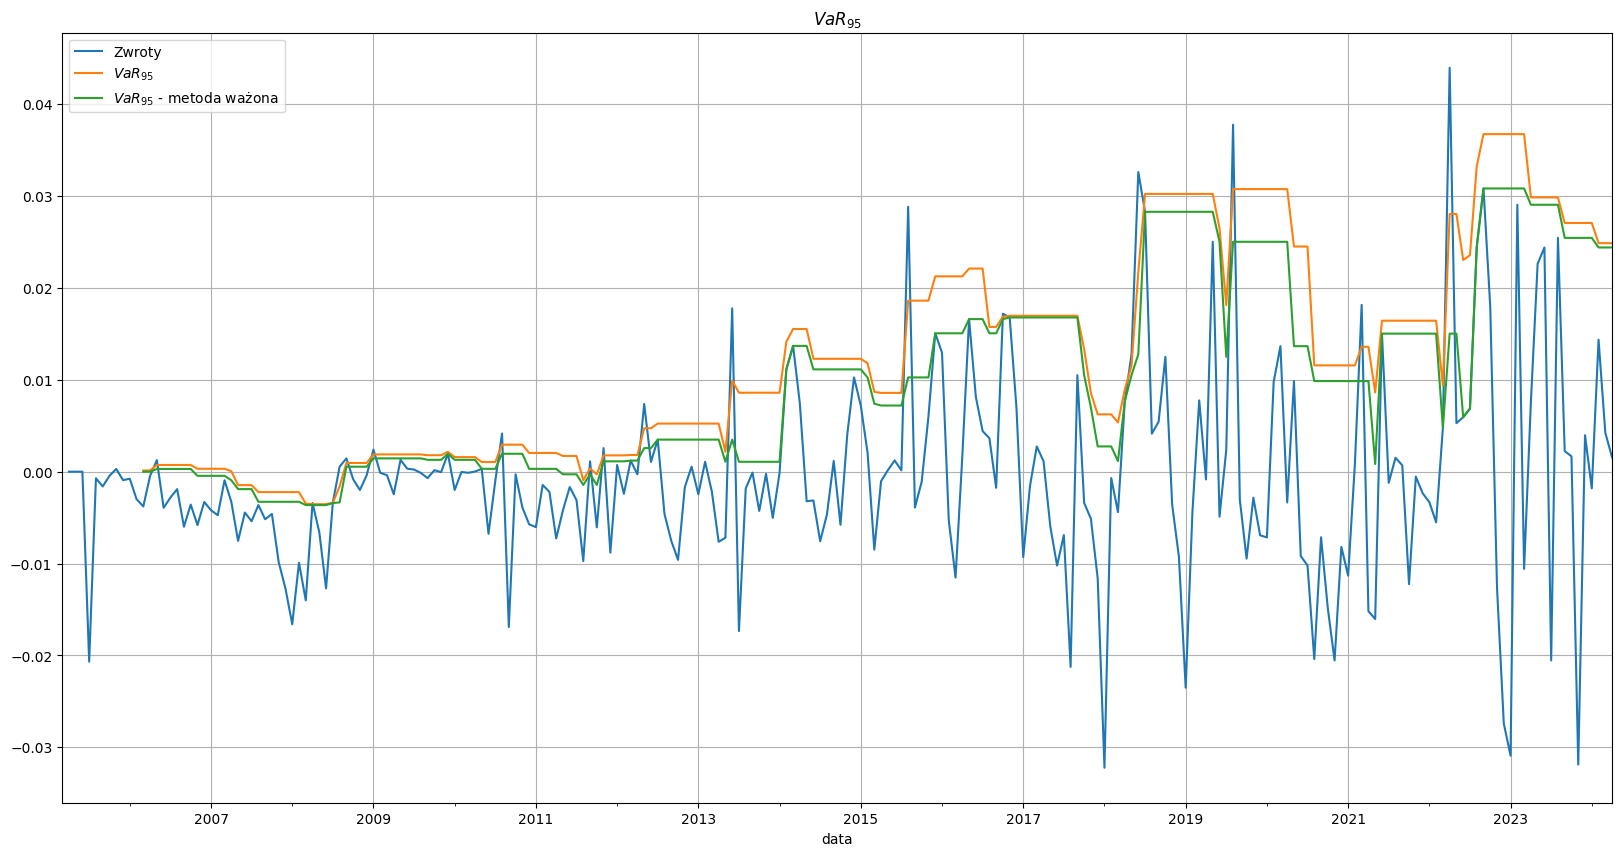

In [42]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist','var95_ważona']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$',
         color=['C0', 'C1', 'C2'])
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{95}$ - metoda ważona'])
plt.savefig(f'pics\\{params["name"]}\\var95_wazony.png')

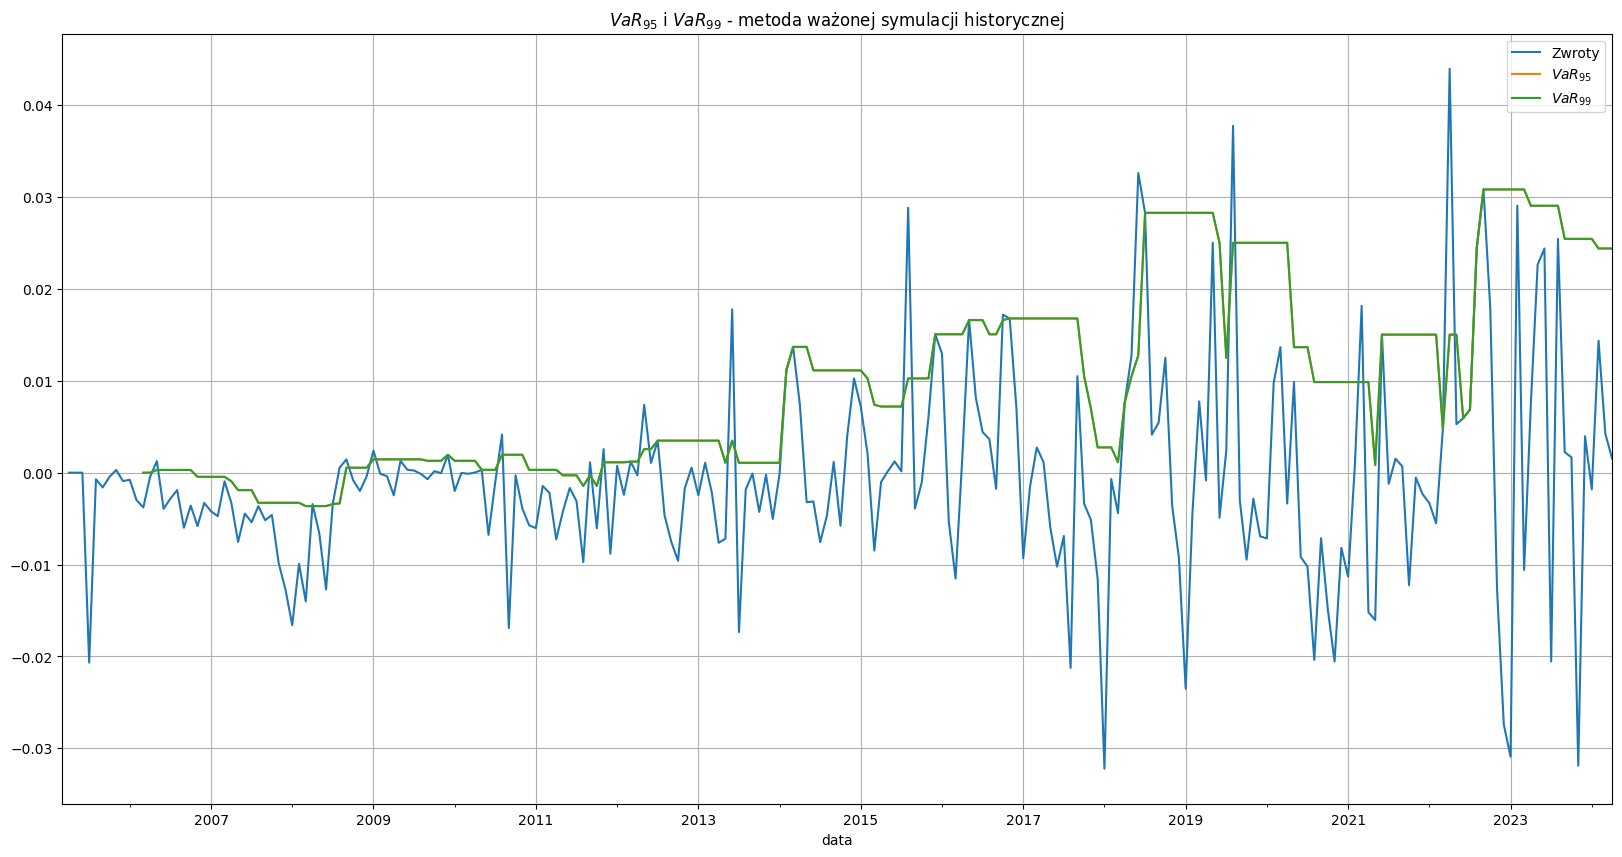

In [43]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_ważona','var99_ważona']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$ i $VaR_{99}$ - metoda ważonej symulacji historycznej',
         color=['C0', 'C1', 'C2'])
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{99}$'])
plt.savefig(f'pics\\{params["name"]}\\var95_99_wazony.png')

In [45]:
data, I95_weighted = exceeds_vector(data, 'ważona')
data, I99_weighted = exceeds_vector(data, 'ważona', alpha99)

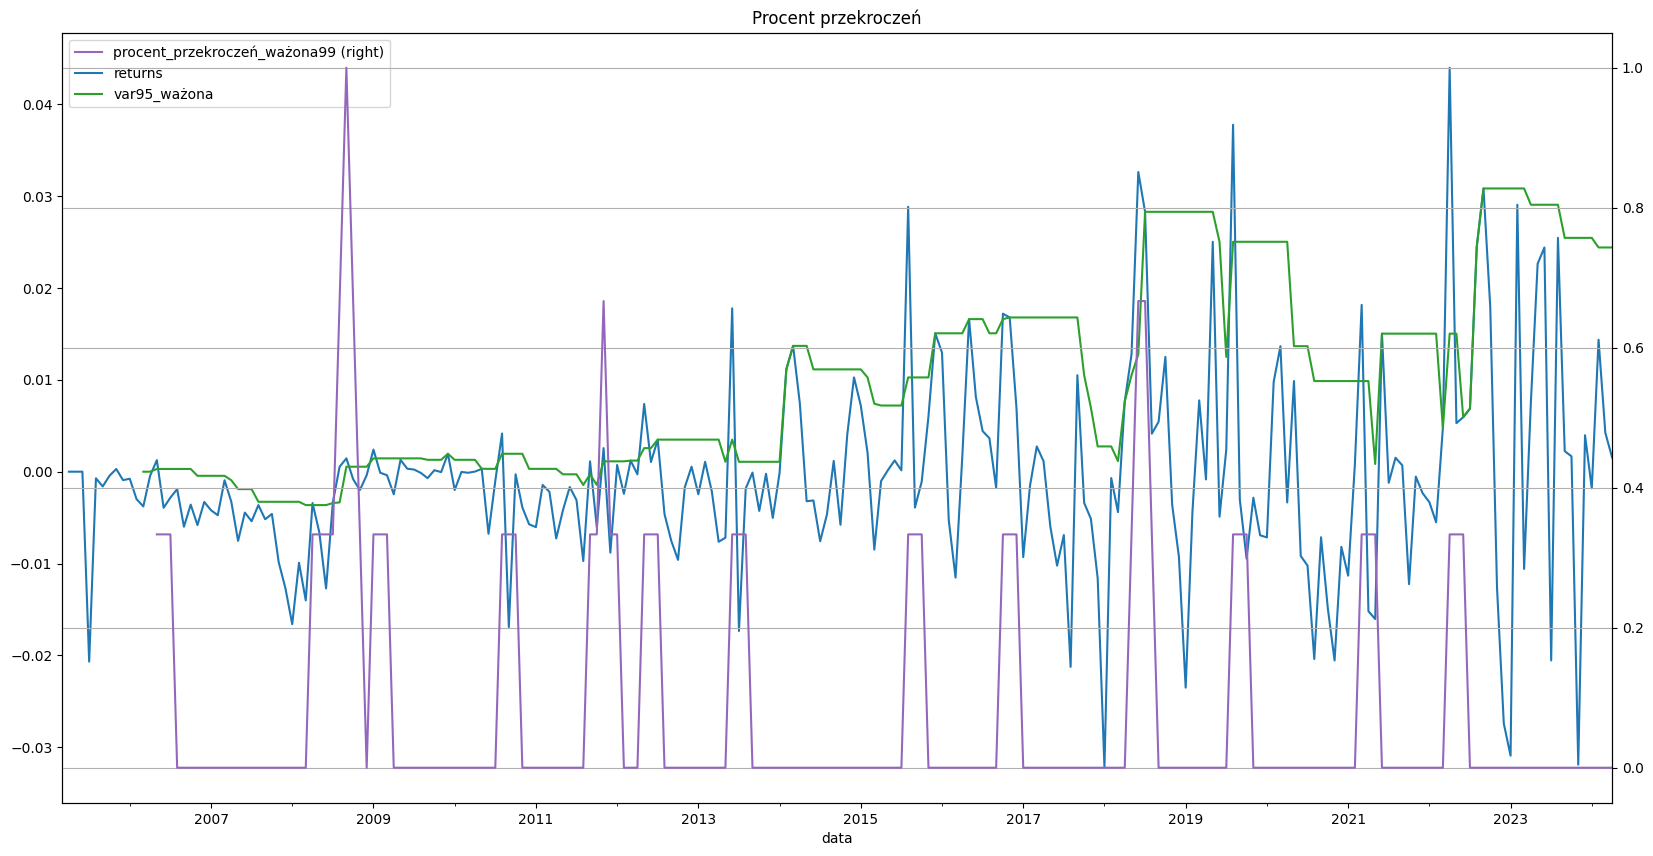

In [48]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['procent_przekroczeń_ważona99']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            legend=True)

_ = data[['returns', 'var95_ważona']].plot(ax=ax,
                                         grid=True,
                                         style=['-', '-'],
                                         color=['C0', 'C2'],
                                         xlabel='data',
                                         title='Procent przekroczeń', legend=True)
plt.savefig(f"pics\\{params['name']}\\procent-var95-ważona.png")

## Testowanie wsteczne

### Rozkład dwumianowy

In [51]:
test_exceeds_vector(I95_weighted, .95)

,empiryczne,teoretyczne
średnia,0.082569,0.9500
wariancja,0.0761,0.0475
binomtest p-wartość,0.040785,NaN
Kupiec - wynik,reject H0,NaN


In [50]:
test_exceeds_vector(I99_weighted, .99)

,empiryczne,teoretyczne
średnia,0.082569,0.9900
wariancja,0.0761,0.0099
binomtest p-wartość,0.0,NaN
Kupiec - wynik,reject H0,NaN


# Metoda filtrowanej symulacji historycznej

In [60]:
%%capture
data = calculate_var(data, lambda x, alpha: garch_var(x, alpha95/100), 'garch')
data = calculate_var(data, lambda x, alpha: garch_var(x, alpha99/100), 'garch', alpha=alpha99)

In [61]:
data, I95_garch = exceeds_vector(data, 'garch', 95)
data, I99_garch = exceeds_vector(data, 'garch', 99)

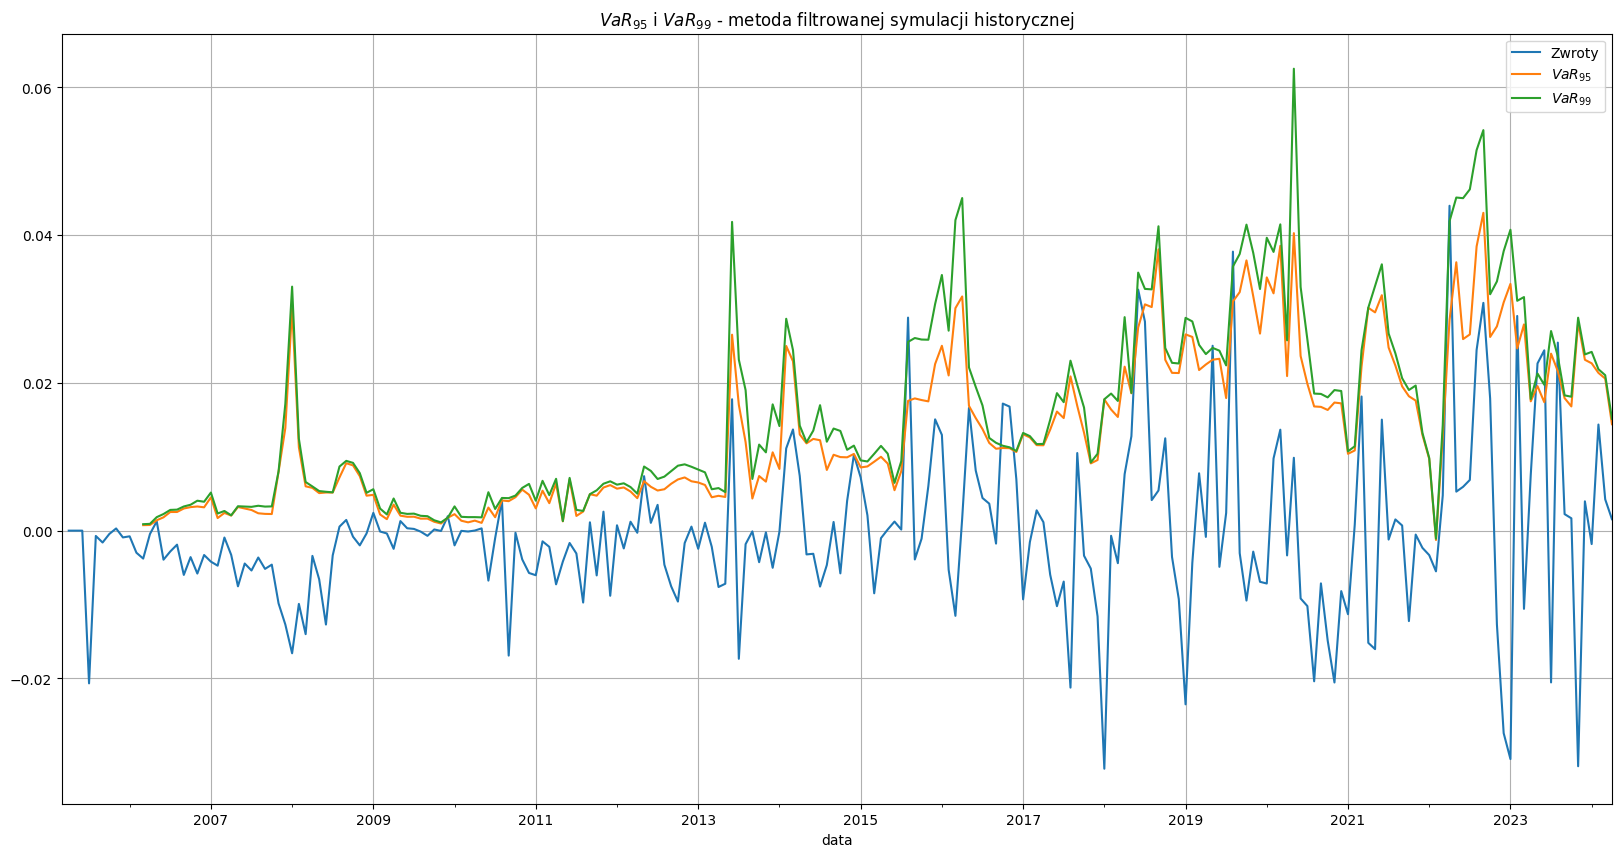

In [64]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_garch','var99_garch']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$ i $VaR_{99}$ - metoda filtrowanej symulacji historycznej',
         color=['C0', 'C1', 'C2'])
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{99}$'])
plt.savefig(f'pics\\{params["name"]}\\var95_99_garch.png')

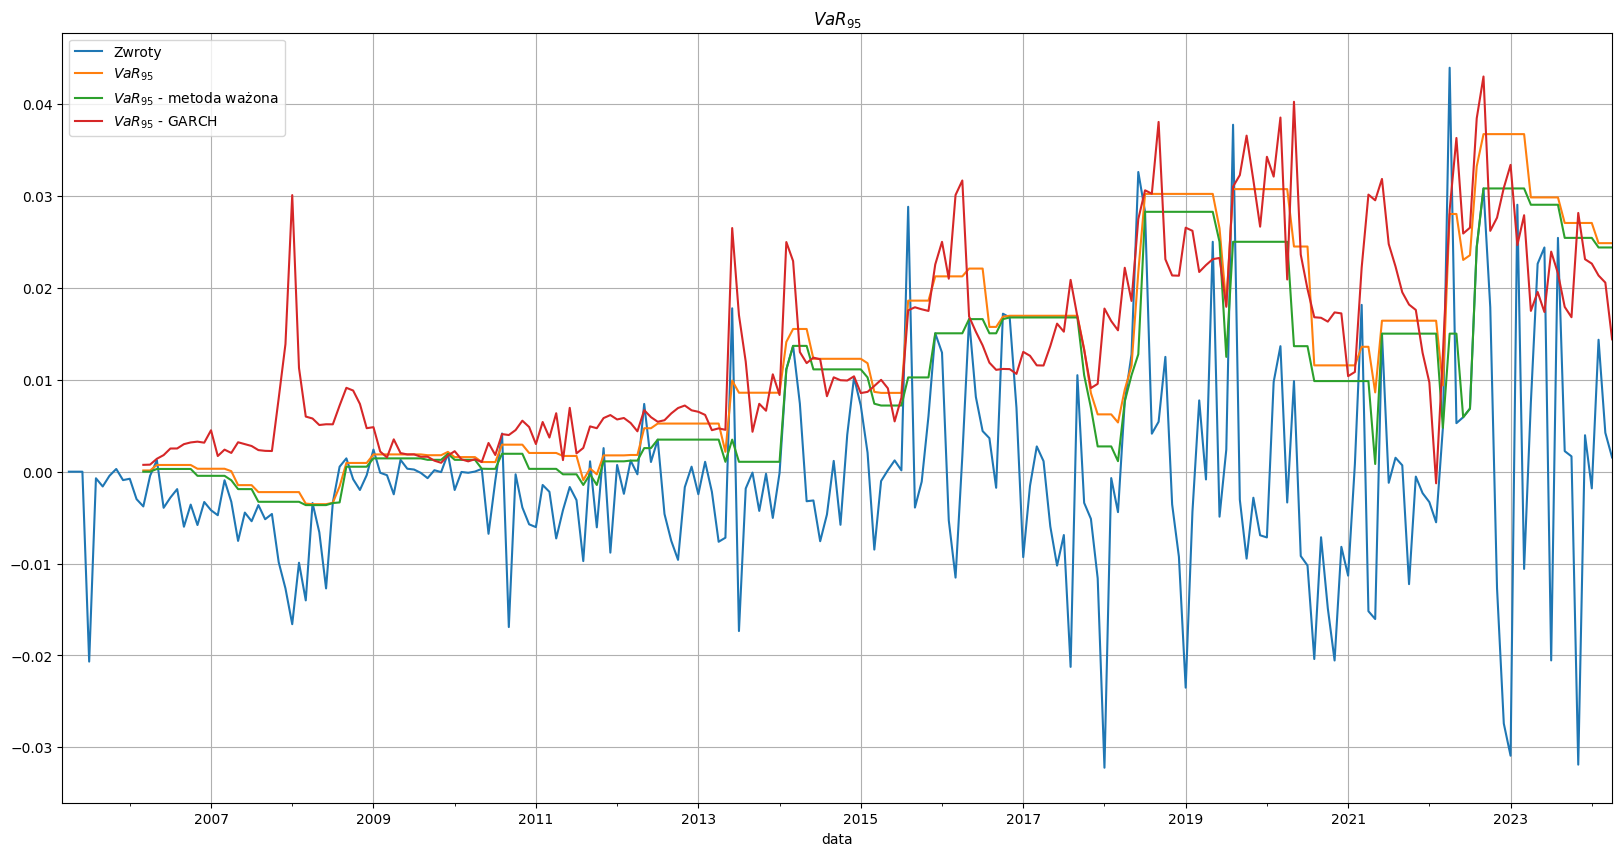

In [62]:
_, ax = plt.subplots(figsize=(20, 10))
_ = data[['returns', 'var95_hist', 'var95_ważona', 'var95_garch']].plot(ax=ax,
                                                                         grid=True,
                                                                         xlabel='data',
                                                                         title='$VaR_{95}$',
                                                                         color=['C0', 'C1', 'C2', 'C3'])
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{95}$ - metoda ważona', '$VaR_{95}$ - GARCH'])
plt.savefig(f'pics\\{params["name"]}\\var95_garch.png')

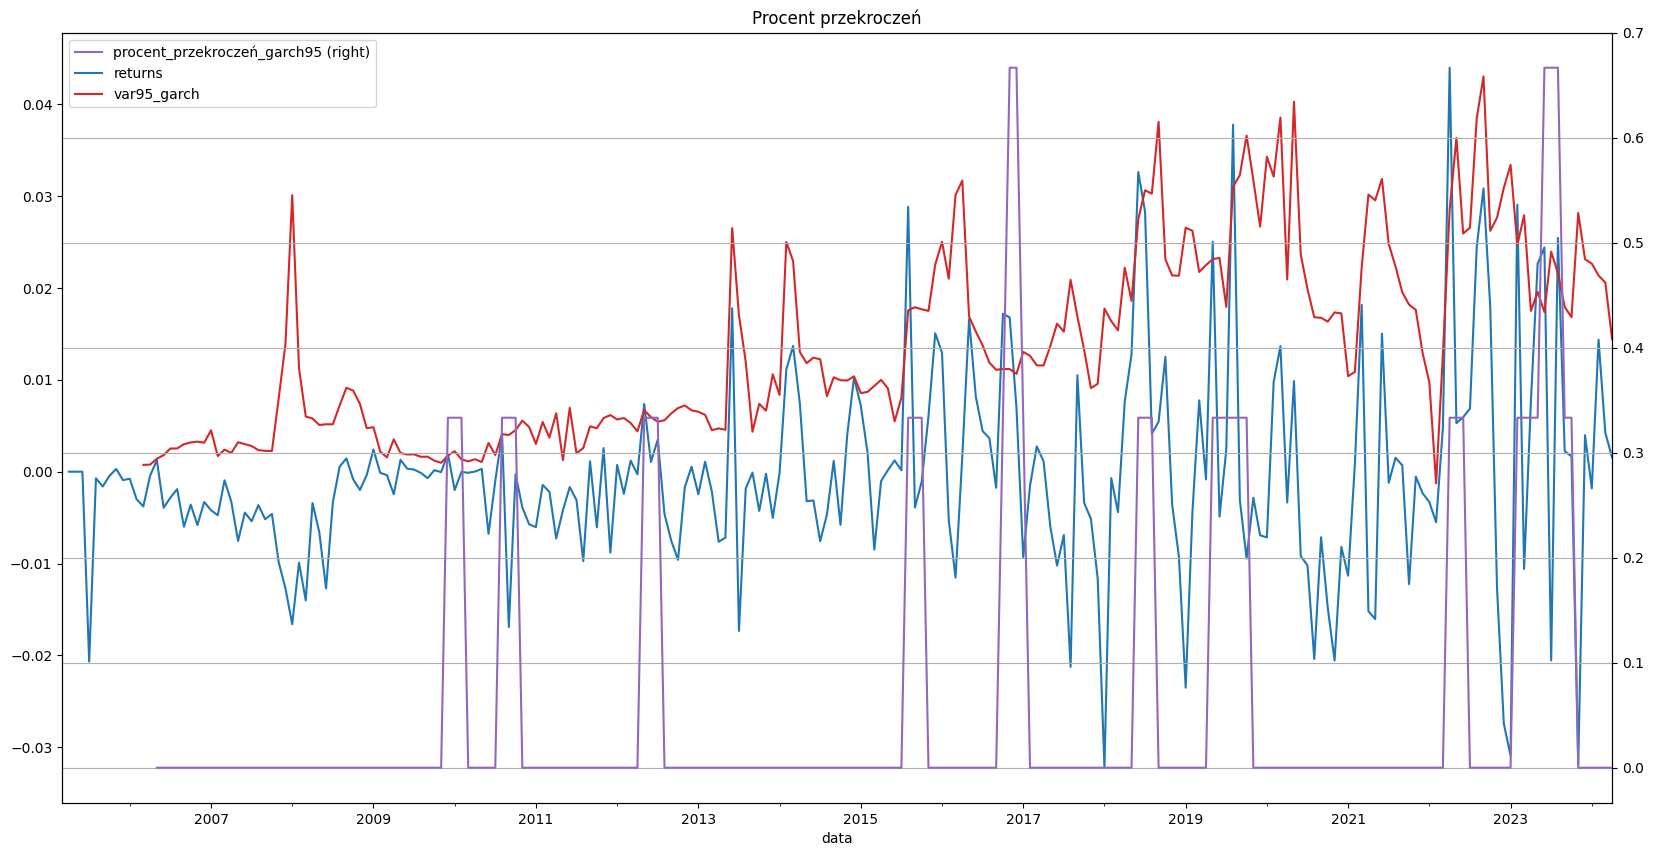

In [63]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['procent_przekroczeń_garch95']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            legend=True)

_ = data[['returns', 'var95_garch']].plot(ax=ax,
                                         grid=True,
                                         style=['-', '-'],
                                         color=['C0', 'C3'],
                                         xlabel='data',
                                         title='Procent przekroczeń', legend=True)
plt.savefig(f"pics\\{params['name']}\\procent-var95-garch.png")

## Testowanie wsteczne

### Rozkład dwumianowy

In [65]:
test_exceeds_vector(I95_garch, .95)

,empiryczne,teoretyczne
średnia,0.06422,0.9500
wariancja,0.060373,0.0475
binomtest p-wartość,0.347701,NaN
Kupiec - wynik,reject H0,NaN


In [66]:
test_exceeds_vector(I99_garch, .99)

,empiryczne,teoretyczne
średnia,0.045872,0.9900
wariancja,0.043969,0.0099
binomtest p-wartość,0.000082,NaN
Kupiec - wynik,reject H0,NaN
